### Imports

In [899]:
import numpy as np
import numba
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import ipywidgets as widgets
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (9,5)

def verlet(S,F,dt,q0,p0,t,nlt=0.25):
    k = p0 + 0.5*dt*F(q0,nlt)
    q = q0 + dt*S(k)
    p = k  + 0.5*dt*F(q,nlt)
    return q,p

# This is a modified version of the symplectic evolve that we did in class.
# This is modified to cater toward our problem, so that the ends are fixed and
# their displacements and momenta are always 0

# The 'nlt' argument is here for later in the code when we create "create_fput"
# It is just a way of passing the nonlinear term to our integrator

def symplectic_evolve(S, # T'(p) -- the speed
                      F, # -V'(q) -- the force
                      t0,t1, # initial and final times
                      N, # number of time steps
                      q0,p0, # initial condition
                      step, # stepping fcn
                      nlt=0.25
                     ):
    T,dt = np.linspace(t0,t1,N,retstep=True)
    Q = np.array([q0 for n in range(0,N)])
    P = np.array([p0 for n in range(0,N)])
    for n in range(0,N-1):
        Q[n+1], P[n+1] = step(S,F,dt,Q[n],P[n],T[n],nlt)
        P[n+1,0]  = 0 # Setting left-most particle momentum to be 0
        P[n+1,-1] = 0 # Setting right-most particle momentum to be 0
        Q[n+1,0]  = 0 # Setting left-most particle displacement to be 0
        Q[n+1,-1] = 0 # Setting right-most particle displacement to be 0
        
    return T,Q,P

### FPUT Experiment Logistics

The equation of motion for the displacement for the $i$-th particle in our system can be modelled with the following.

$$
m\ddot{x_i} = k(x_{i+1} + x_{i-1} - 2x_i) + \epsilon(x_i)
$$

where 

$\epsilon(x_i) \equiv \alpha[(x_{i+1} - x_i)^2 - (x_i - x_{i-1})^2]$ for a quadratic non-linear term, or 

$\epsilon(x_i) \equiv \beta[(x_{i+1} - x_i)^3 - (x_i - x_{i-1})^3]$ for a cubic non-linear term

with $i = 0,1,2,...,N-1$

Our problem is approached using a symplectic method. The requirements for a symplectic integrator are as follows:

$$
\begin{align}
\dot{q} &= +\frac{\partial H}{\partial p} = +T'(p) \equiv S(p) \\
\dot{p} &= -\frac{\partial H}{\partial q} = -V'(q) \equiv F(q)
\end{align}
$$

Luckily, we already have an equation for our force as described above, since the provided equation of motion is just Newton II.

What we are missing is our time derivative of our kinetic energy. The kinetic energy of a particle is just the standard model with respect to momentum:

$$
T_i = \frac{p_i^2}{2m}
$$

And so if we take the time derivative of this, we will have all we need. Therefore, our equations of motion for our symplectic integrator are:

$$
S(p_i) \equiv \frac{p_i}{m}
$$

$$
F(x_i) \equiv k(x_{i+1} + x_{i-1} - 2x_i) + \epsilon(x_i)
$$

In [900]:
@numba.njit
def F_quad(x,α=0.25,k=1):
    #return k*(np.roll(x,-1) + np.roll(x,1) - 2*x)*(1 + α*(np.roll(x,-1) - np.roll(x,1)))
    return k*(np.roll(x,-1) + np.roll(x,1) - 2*x) + α*((np.roll(x,-1) - x)**2 - (x - np.roll(x,1))**2)

@numba.njit
def F_cubic(x,β=1/8,k=1):
    return k*(np.roll(x,-1) + np.roll(x,1) - 2*x) + β*((np.roll(x,-1) - x)**3 - (x - np.roll(x,1))**3)

@numba.njit
def S(p,m=1):
    return p/m

### Setting up the system

Our string is a system of $N$ particles equally spaced by a distance $\Delta x$

We define our equilibrium positions with:

$$
P_i = i\Delta x
$$

with $i = 0,1,...,N-1$

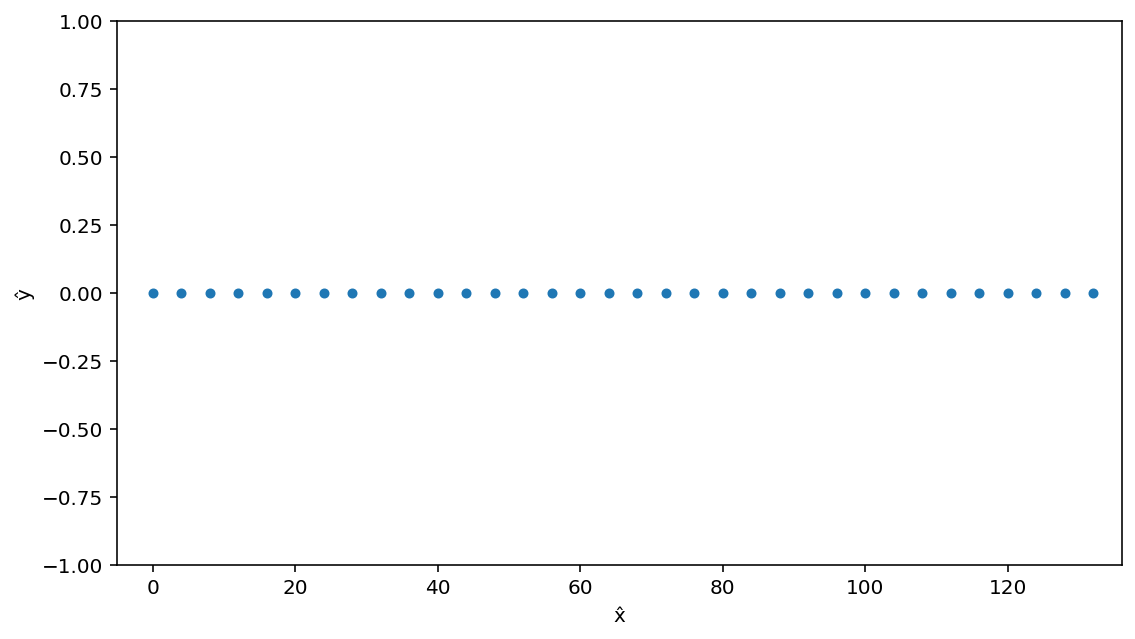

In [901]:
N    = 32           # Number of oscillators
tmax = 70000       # Total time
δt   = 0.1          # Time step
Nt   = int(tmax/δt) # Number of time steps
l    = 124          # Length of string (just for aesthetics)
Δx   = l/(N-1)      # Lattice spacing (just for aesthetics)

# +2 because we need two particles on each end that are fixed
P = np.array([i*Δx for i in range(0,N+2)]) # Equilibrium positions

plt.xlim(-5,Δx*(N+2))
plt.ylim(-1,1)
plt.xlabel("x̂")
plt.ylabel("ŷ")
plt.plot(P,np.zeros(N+2),lw=0,marker='.',ms=8)

### Initial Configuration - Half of a Sine Wave

We can define the initial displacements of our string to be set as half of a sine wave, i.e.:

$$
x_i = \sin(\frac{i\pi}{N+1})
$$

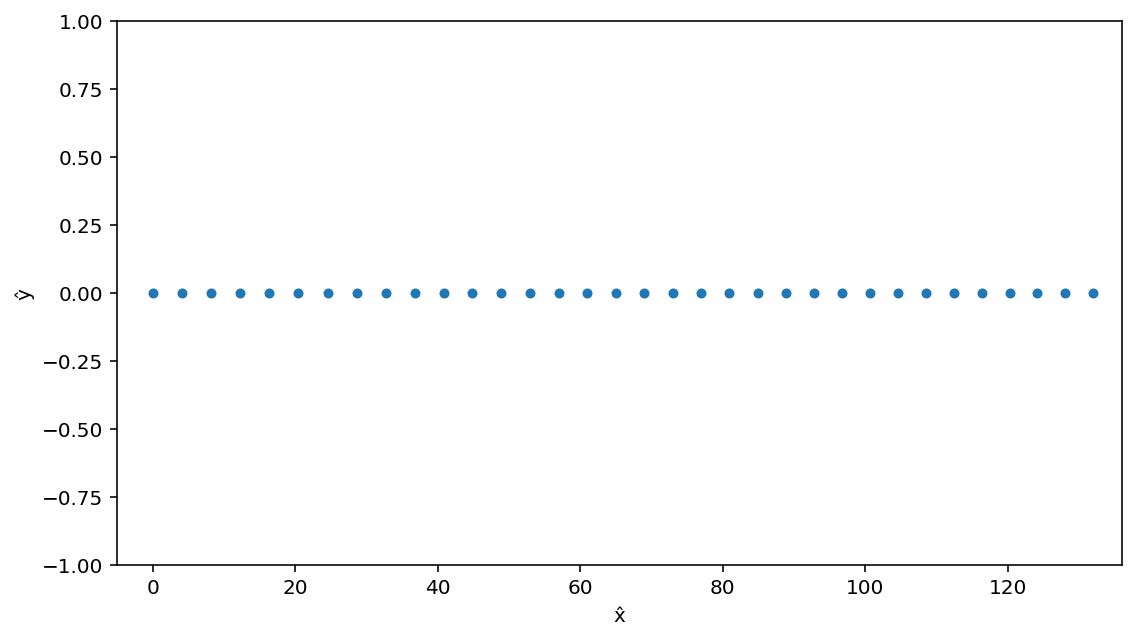

In [902]:
# Setting up wave
x = np.zeros(N+2)
for i in range(1,N+1):
    x[i] = np.sin(i*np.pi/(N+1))

plt.xlim(-5,Δx*(N+2))
plt.ylim(-1,1)
plt.xlabel("x̂")
plt.ylabel("ŷ")
plt.plot(P+x,np.zeros(N+2),lw=0,marker='.',ms=8)

Our problem is modelled has half of a sine wave.

Although, looking at the graph, it is hard to tell that this is the case. We can make the graph easier to read by plotting the displacements along the y-axis. We will do this every time going forward.

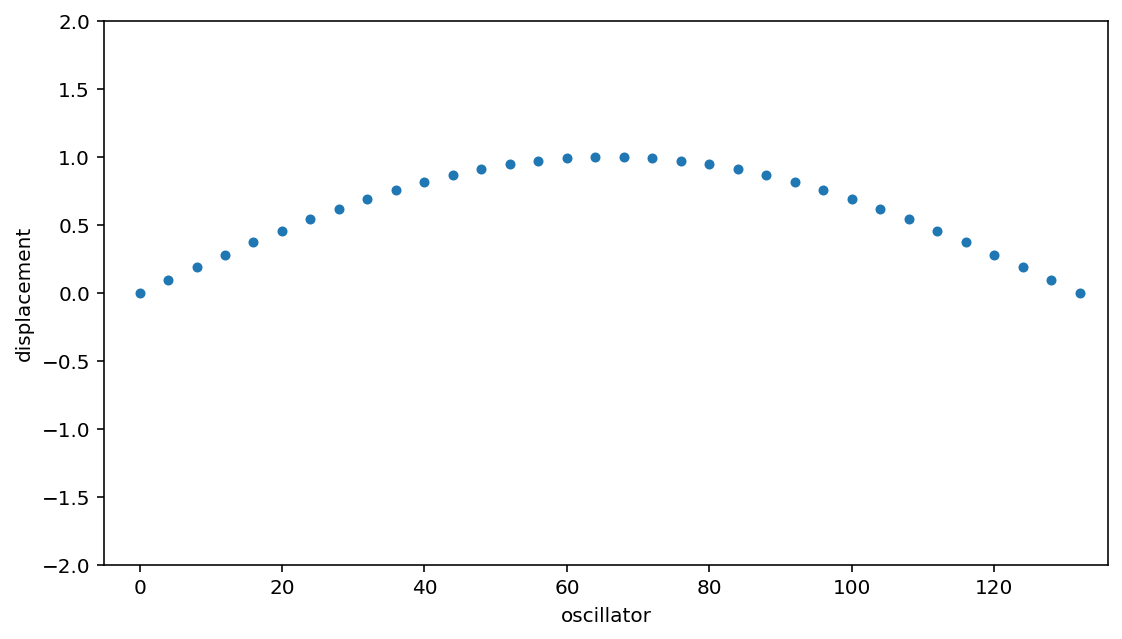

In [903]:
plt.xlim(-5,Δx*(N+2))
plt.ylim(-2,2)
plt.xlabel("oscillator")
plt.ylabel("displacement")
plt.plot(P,x,lw=0,marker='.',ms=8)

It is now much easier to see that this is a half-sine wave. It will also be easier to see the behavior of the string, as we evolve it in time. Now that we have our setup, we can use the symplectic integrator we built along with a widget to move it forward in time.

In [904]:
# Symplectic integrator: returns time, position and momentum arrays respectively
T,X,p = symplectic_evolve(S,F_quad,0.0,tmax,Nt,x,np.zeros(N+2),step=verlet)

In [905]:
@widgets.interact(t=(0.0,tmax,tmax/Nt*10))
def disp(t=0):
    it = int((t/tmax)*(Nt-1))
    plt.xlim(-10,Δx*(N+2))
    #plt.ylim(-h*(N+2),h*(N+2))
    plt.ylim(-800,800)
    plt.plot(P,np.zeros(N+2),lw=0,marker='.',ms=8,label='equilibrium')
    plt.plot(P,500*X[it,:],lw=0,marker='.',ms=8,label='X')
    plt.xlabel('oscillator')
    plt.ylabel('displacement(x500)')
    plt.legend()

interactive(children=(FloatSlider(value=0.0, description='t', max=70000.0, step=1.0), Output()), _dom_classes=…

### Modal Energy

To describe our modal energy, we need to change our variables to describe our system in Fourier modes:

$$
a_k = \sum_i x_i \sin(\frac{ik\pi}{N})
$$

We can take the time derivative, as we are going to need it for the total energy, which is simply:

$$
\dot{a_k} = \sum_i \dot{x_i} \sin(\frac{ik\pi}{N})
$$

Which then our total energy for the $k$-th mode is defined as:

$$
E_k = \frac{1}{2}(\dot{a_k^2} + \omega_k^2 a_k^2)
$$

With $\omega_k = 2\sin(\frac{k\pi}{2N})$

Now, our system has $N$ modes. Noticing the summation in $a_k$ and $\dot{a_k}$, this can be quite expensive for us to compute over our time interval ( ~$O(K*N*t_{max})$ )

A way around this is by setting a resolution of our graph `res`. This will only calculate the energy after every step `step`. So although our graph won't have every single time's energy in it, we can still make out the shape of the graph just the same as we would have without this method. This does a great job at speeding up our computation time.

We will plot the energy over the period for convience when reading the graph.

We can do this by defining the variable `step`, then calculating the resolution by:

$Nt \equiv$ # of time steps

$$
res = \frac{Nt}{step}
$$

So our energy will have a size of `res` but will span over all of the time steps

In [906]:
K    = 4            # number of modes to calculate
step = 50           # step for energy calculation
res  = int(Nt/step) # 'resolution' of graph

a = np.zeros((K,res))
ȧ = np.zeros((K,res))
ω = np.zeros((K,res))
E = np.zeros((K,res))

for ik in range(0,K):
    for it in range(0,Nt,step):
        ω[ik,int(it/step)] = 2.0*np.sin(ik*np.pi/2.0/N)
        for n in range(1,N):
            a[ik,int(it/step)] += X[it,n] * np.sin(n*ik*np.pi/N)
            ȧ[ik,int(it/step)] += p[it,n] * np.sin(n*ik*np.pi/N)

E = 0.5*(ȧ**2 + ω**2 * a**2)

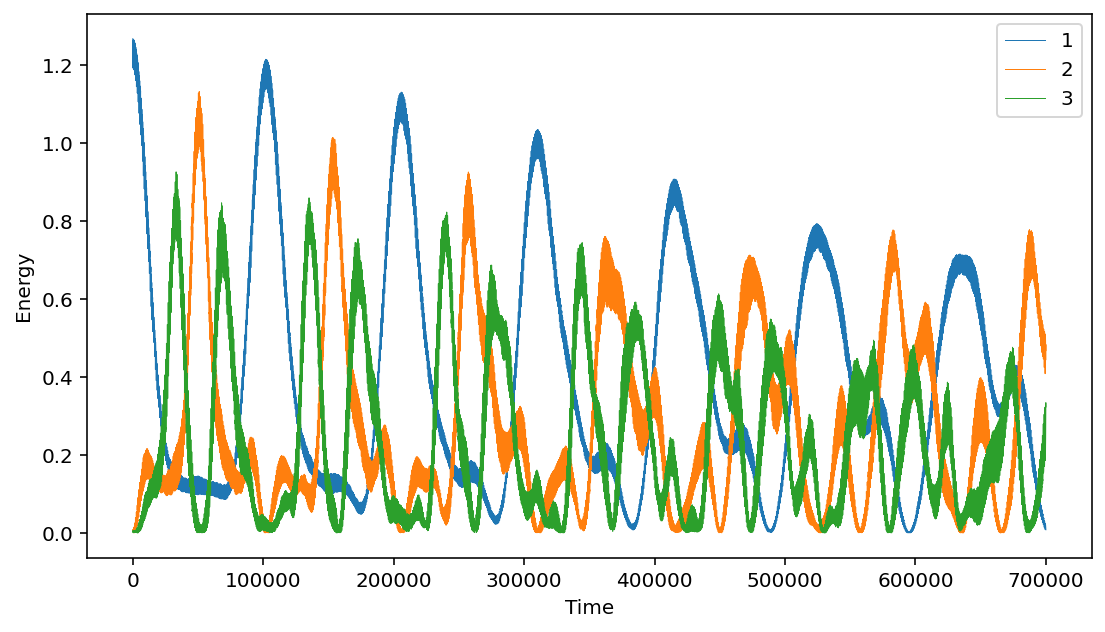

In [907]:
#W = ω[1]/2/np.pi
#τ = W*np.linspace(0,Nt,res)
τ = np.linspace(0,res,res)

for ik in range(1,K):
    plt.plot(τ*step,E[ik],lw=0.5,label=str(ik))

plt.xlabel('Time')
plt.ylabel('Energy')
plt.legend()

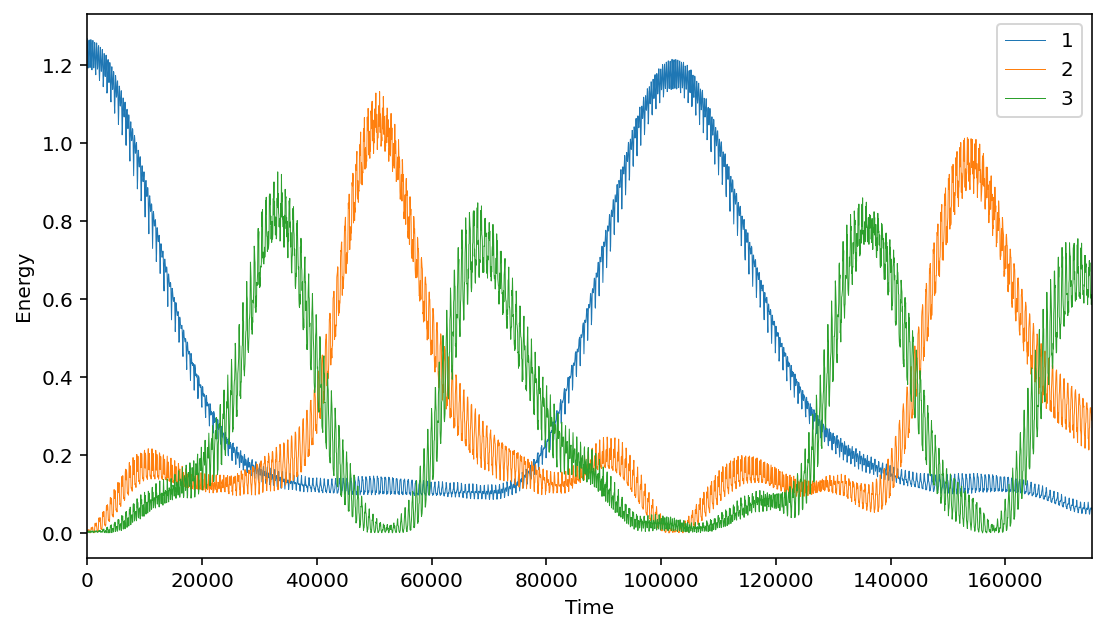

In [908]:
# Zooming in on ~ one and a half periods
for ik in range(1,K):
    plt.plot(τ*step,E[ik],lw=0.5,label=str(ik))
plt.xlim(0,175000)
plt.xlabel('Time')
plt.ylabel('Energy')
plt.legend()

We want to compare the values of the two critical values of energy near $t = 0$ and $t \approx 10500$.

We can do this using simple percent error:

$$
\frac{|E_{1,max1} - E_{1,max2}|}{E_{1,max1}}
$$

We also have to be careful when finding the maximum points on our graph because of our scaling with the resolution. Since our time array has a size of `Nt`, but our energy array has a size of `res`, we can look for energy values at a given time by using the index of `time` divided by the `step`

In [909]:
E1 = E[1,0]
E2 = np.max(E[1,int(80000/step):int(120000/step)])
print(f"Energy loss between first two initial conditions: {int(np.abs(E1-E2)/E1 * 1000000)/10000}%")

Energy loss between first two initial conditions: 4.1802%


We find that our energy loss is ~4%. We know that we will not maintain our energy over each quasi period, but this is a good approximation.

### Phase space

We can plot the phase space of our example as well, where the slider changes each particle's phase space. We can also lay it out with the time dimension added.

In [910]:
@widgets.interact(ip=(0.0,N,1))
def disp(ip=0):
    ip = int((ip))
    plt.xlim(-1.1,1.1)
    plt.ylim(-0.15,0.15)
    plt.scatter(X[:,ip],p[:,ip],s=0.1,c=T)
    plt.xlabel('x')
    plt.ylabel('p')

interactive(children=(FloatSlider(value=0.0, description='ip', max=32.0, step=1.0), Output()), _dom_classes=('…

In [911]:
@widgets.interact(ip=(0.0,N,1))
def disp(ip=0):
    ip = int((ip))
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(T,X[:,ip],p[:,ip],s=0.0005)
    ax.set_xlabel("Time")
    ax.set_ylabel("Position")
    ax.set_zlabel("Momentum")

interactive(children=(FloatSlider(value=0.0, description='ip', max=32.0, step=1.0), Output()), _dom_classes=('…

Now that we have shown that we can display general properties of our system (the string oscillating, the modal energy, and phase space), we need to study different configurations of our string. We are going to study how the non-linear term affects our graph, along with the initial configuration. Lastly, we will attempt to find a way to predict the frequency of our system over small quasi-periods.

We will write a function `create_fput` that will create a system based on the parameters we input. It will take all of the different properties of our system, along with a time range so that it can evolve it in time. This function will do the following:

- Create the system, based on parameters
- Evolve it in time
- Return the position, time, and momentum arrays along with an array of the modal energies

Our function will still use the symplectic methods defined above. We will also allow for the `step` to be passed as well so that the computation times and resolution is flexible. An argument `force` will be added so we can swap between the quadratic and cubic non-linear term with ease. It will also take a parameter for a function`init`, which defines the initial configuration. Lastly, the parameter `nlt` is added so that we can change the nonlinear term as we please.

In [912]:
# Function for default configuration of string
def hsw(i,N):
    return np.sin(i*np.pi/(N+1))

# Function to create an FPUT system
def create_fput(N,            # Number of oscillators
                l,            # Length of the string
                tf,           # Time
                δt,           # Time step
                force=F_quad, # Force function, defaulted to quadratic
                nlt = 0.25,   # Nonlinear term
                init=hsw,     # Initial configuration (function), default to half sine wave
                Ki=0,         # Initial mode to calculate
                Kn=4,         # Number of modal energies to calculate, default to 4
                step=1        # Step for modal energy calculation, default to 1
                ):
    
    Δx  = l/(N-1)                                # Lattice spacing
    P   = np.array([i*Δx for i in range(0,N+2)]) # Equilibrium positions
    x   = np.zeros(N+2)                          # Displacements (full array of 0's for now)
    Nt  = int(tf/δt)                             # Number of time steps
    res = int(Nt/step)                           # Resolution of modal energy array
    for i in range(1,N+1):                       # Putting equilibrium positions as the initial displacements                  
        x[i] = init(i,N)  
        
    # Evolving our system in time
    T,X,p = symplectic_evolve(S,force,0.0,tf,Nt,x,np.zeros(N+2),step=verlet,nlt=nlt)
    
    # Arrays full of 0's (for now) to calculate modal energies
    a = np.zeros((K,res))
    ȧ = np.zeros((K,res))
    ω = np.zeros((K,res))
    E = np.zeros((K,res))

    # Calculating values to put into equation for modal energy
    for ik in range(0,Kn):
        ik2 = Ki+ik
        for it in range(0,Nt,step):
            ω[ik,int(it/step)] = 2.0*np.sin(ik2*np.pi/2.0/N)
            for n in range(1,N):
                a[ik,int(it/step)] += X[it,n] * np.sin(n*ik2*np.pi/N)
                ȧ[ik,int(it/step)] += p[it,n] * np.sin(n*ik2*np.pi/N)
                
    E = 0.5*(ȧ**2 + ω**2 * a**2) # Calculating modal energy
    τ = np.linspace(0,res,res)   # Creating time space for modal energy
    
    return P,T,X,p,E,τ

### Initial configurations

So now, what the string actually looks like as it is vibrating in time is irrelevant. We mainly want to focus on the energies, and the different effects our initial setups have on it. 

We are going to look at two different set-ups:

- $x_i = \frac{1}{\sqrt{N+1}}\sin(\log(\frac{x\pi}{N+1}))$ (i.e. a "checkmark")
- $x_i = \frac{1}{\sqrt{N+1}}\tanh(i)$ (i.e. a normalized hyperbolic tan function)

Both of these setups are ran with $N=32$ and $\alpha = 0.25$

In [913]:
# Property definitions
N    = 32
l    = 124
tmax = 200000
δt   = 0.1
step = 50

In [914]:
# First set-up
def seesaw(i,N):
    return 1/np.sqrt(N+1)*np.sin(np.log(i*np.pi/(N+1)))

P,T,X,p,E,τ = create_fput(N,l,tmax,δt,init=seesaw,step=step)

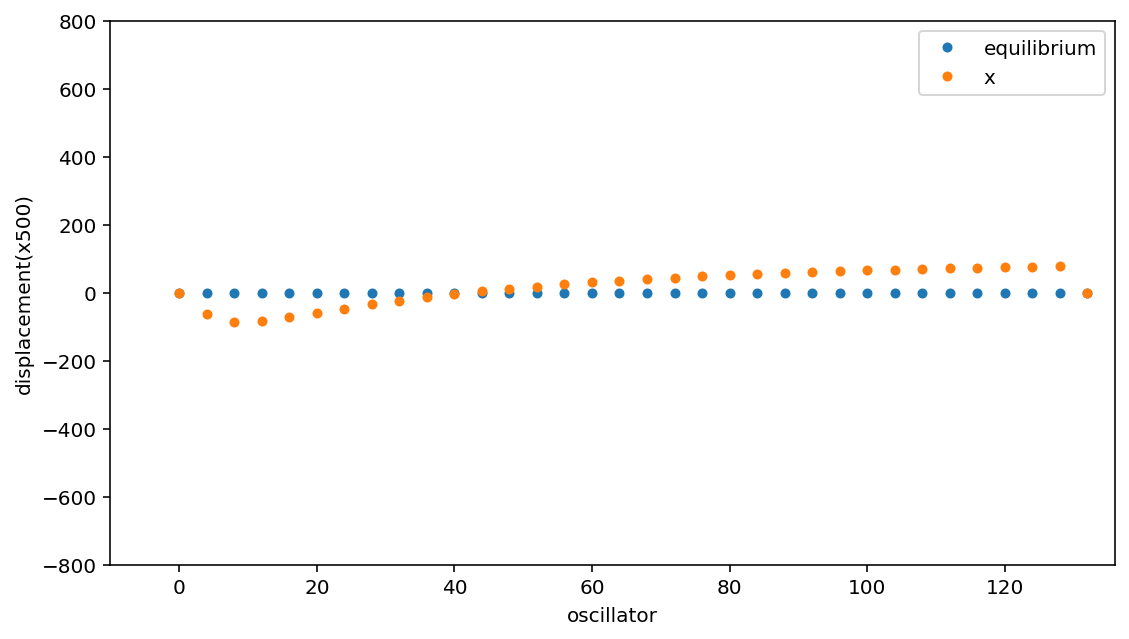

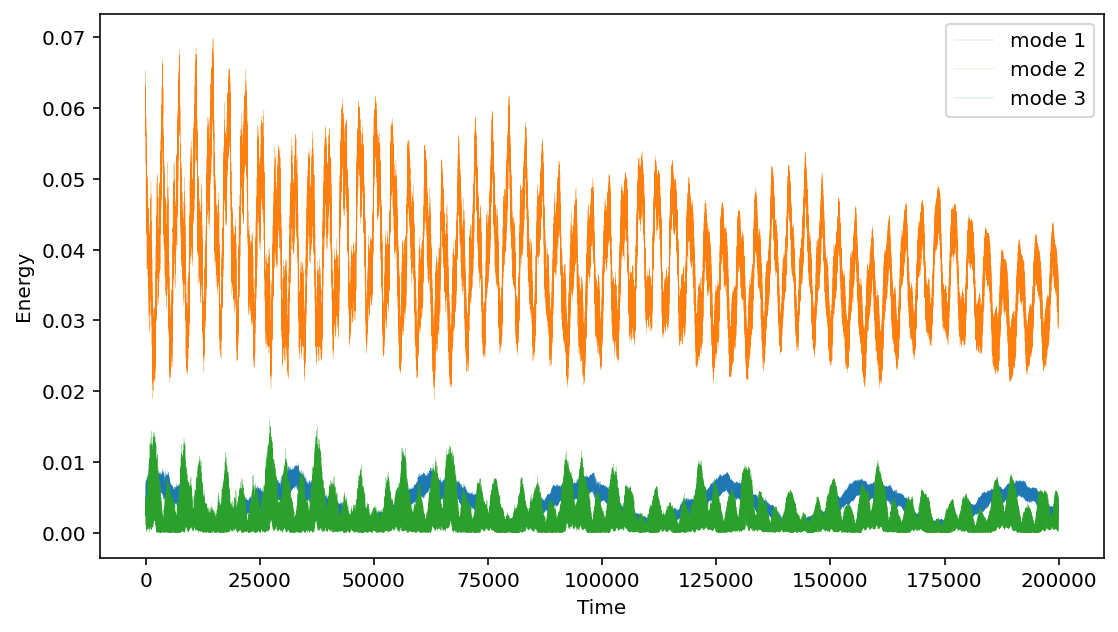

In [915]:
# Displaying initial configuration along with modal energy

plt.xlim(-10,Δx*(N+2))
plt.ylim(-800,800)
plt.plot(P,np.zeros(N+2),lw=0,marker='.',ms=8,label='equilibrium')
plt.plot(P,500*X[0,:],lw=0,marker='.',ms=8,label='x')
plt.xlabel('oscillator')
plt.ylabel('displacement(x500)')
plt.legend()
plt.figure()

for ik in range(1,4):
    plt.plot(τ*step*δt,E[ik],lw=0.1,label="mode "+str(ik))
    plt.xlabel("Time")
    plt.ylabel("Energy")
    plt.ticklabel_format(style='plain') # to prevent scientific notation.
    plt.legend()

We can see above that our energy does exhibit periodic behavior. It is more obvious in mode 1, where we can see the 'peaks' and how similar they are and how consistently frequent they appear:

An interesting thing to note, is that although it seems like we are looking at ~6 periods below, we are actually looking at only 2! We can notice how there are a set of three waves that appear in each period. One of the waves is symmetric, one of the waves is shifted to the left, and one is shifted to the right:

Text(146000, 0.0095, '<- Period ->')

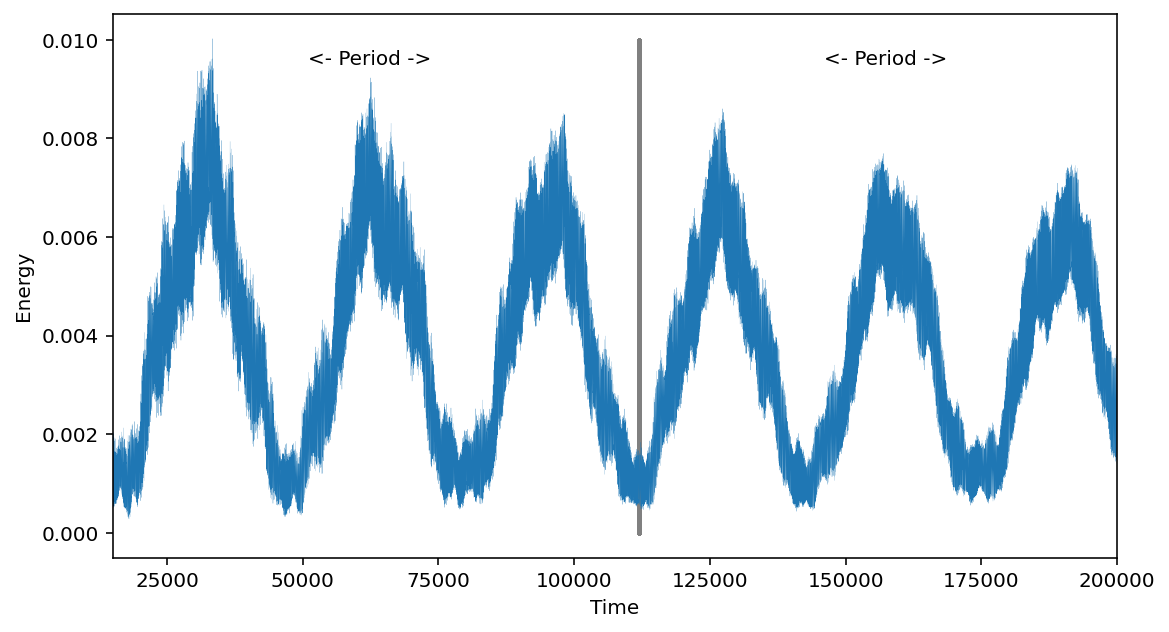

In [916]:
plt.xlim(15000,200000)
#plt.ylim(0,0.02)
plt.plot(τ*step*δt,E[1],lw=0.1)
plt.xlabel("Time")
plt.ylabel("Energy")
plt.ticklabel_format(style='plain') # to prevent scientific notation.
plt.scatter(np.full(len(τ),112000),np.linspace(0,0.01,len(τ)),s=1,c='grey')
plt.text(51000,0.0095,"<- Period ->")
plt.text(146000,0.0095,"<- Period ->")

In [917]:
# Second set-up
def normalized_tanh(i,N):
    return 1/np.sqrt(N+1)*np.tanh(i)

P,T,X,p,E,τ = create_fput(N,l,tmax,δt,init=normalized_tanh,step=step)

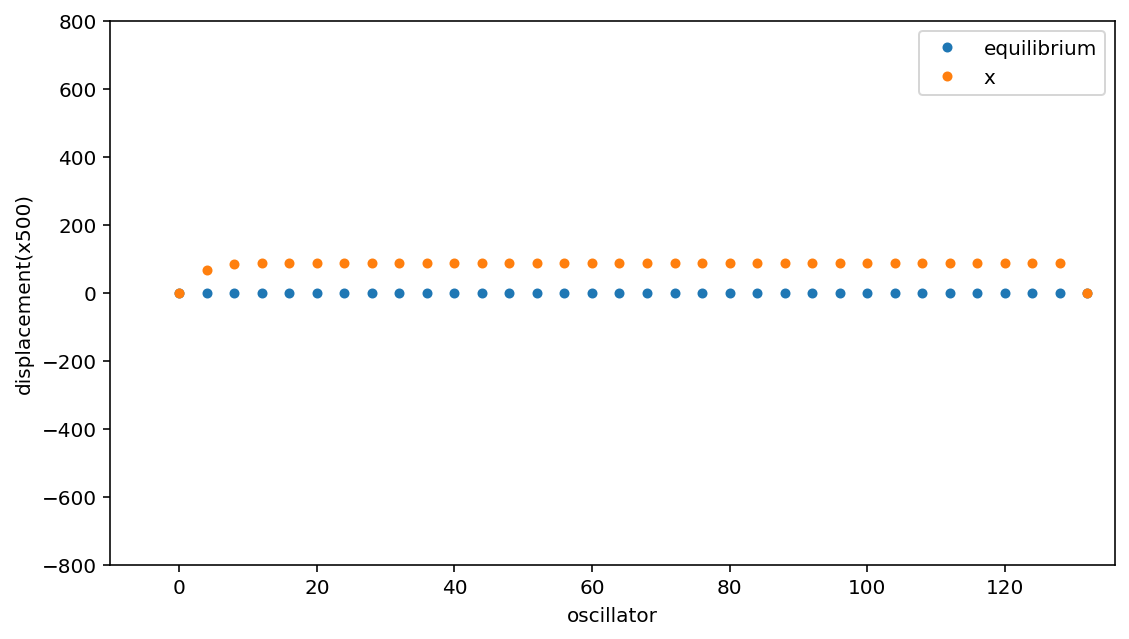

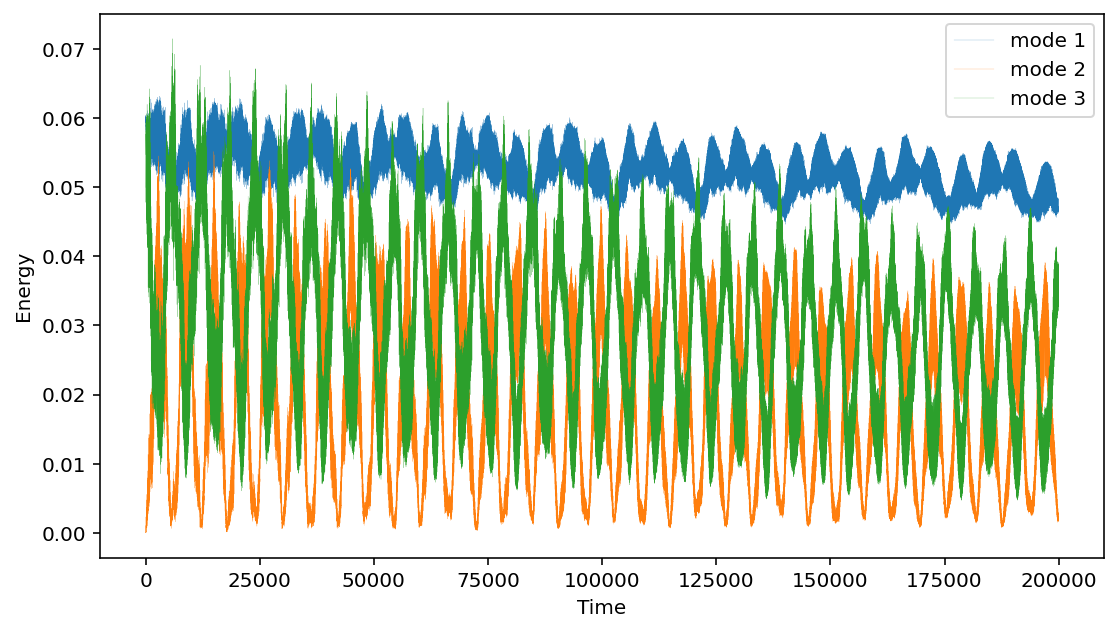

In [918]:
# Displaying initial configuration along with modal energy

plt.xlim(-10,Δx*(N+2))
plt.ylim(-800,800)
plt.plot(P,np.zeros(N+2),lw=0,marker='.',ms=8,label='equilibrium')
plt.plot(P,500*X[0,:],lw=0,marker='.',ms=8,label='x')
plt.xlabel('oscillator')
plt.ylabel('displacement(x500)')
plt.legend()
plt.figure()

for ik in range(1,4):
    plt.plot(τ*step*δt,E[ik],lw=0.1,label="mode "+str(ik))
    plt.xlabel("Time")
    plt.ylabel("Energy")
    plt.ticklabel_format(style='plain') # to prevent scientific notation.
    plt.legend()

Again, we can inspect the first mode. We seem to have a much greater frequency for this case.

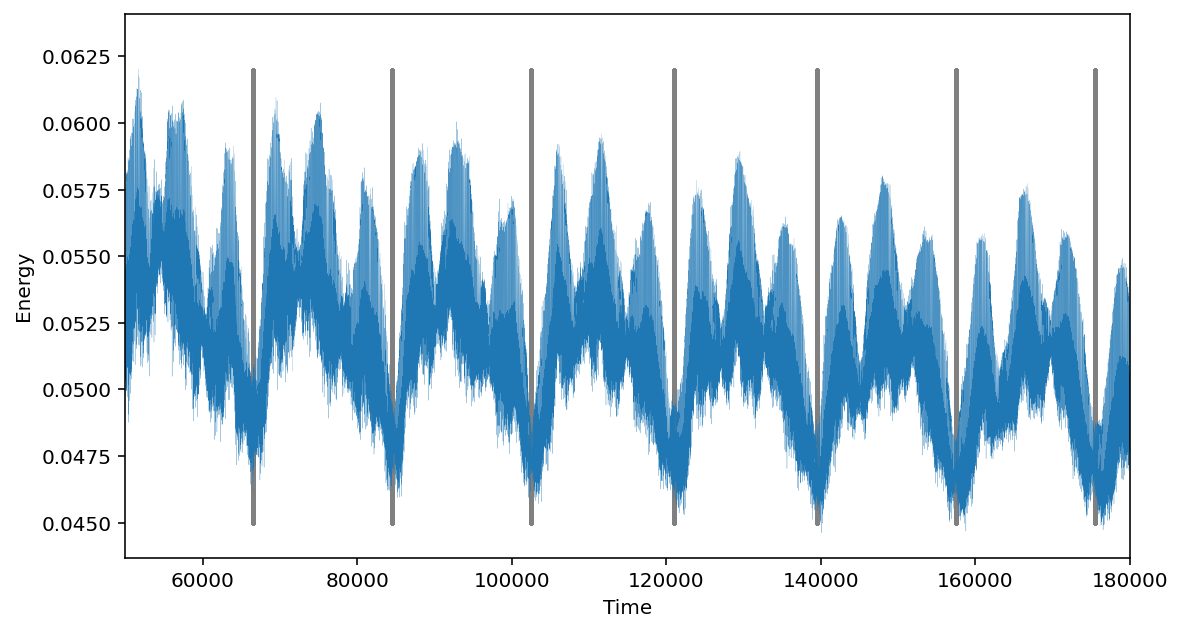

In [919]:
plt.xlim(50000,180000)
#plt.ylim(0,0.02)
plt.plot(τ*step*δt,E[1],lw=0.1)
plt.xlabel("Time")
plt.ylabel("Energy")
plt.ticklabel_format(style='plain') # to prevent scientific notation
Τ = np.linspace(0.045,0.062,len(τ))
plt.scatter(np.full(len(τ),66500),Τ,s=1,c='grey')
plt.scatter(np.full(len(τ),84500),Τ,s=1,c='grey')
plt.scatter(np.full(len(τ),102500),Τ,s=1,c='grey')
plt.scatter(np.full(len(τ),121000),Τ,s=1,c='grey')
plt.scatter(np.full(len(τ),139500),Τ,s=1,c='grey')
plt.scatter(np.full(len(τ),157500),Τ,s=1,c='grey')
plt.scatter(np.full(len(τ),175500),Τ,s=1,c='grey')

### Nonlinear Terms

We will now explore the effects our nonlinear term has on our system.

We want to hold all variables constant except for our nonlinear term - this includes the initial configuration. We will pick the half-sine wave of 32 particles because of its noticeably clear shape.

We will plot the energy first with $\alpha = 0.25$, $\alpha = 0.30$, and $\alpha = 0.35$ and measure the frequency. We will focus again on the first mode.

In [920]:
# Property definitions
tmax = 400000
δt   = 0.1
step = 250

In [921]:
P,T,X,p,E,τ       = create_fput(N,l,tmax,δt,F_quad,nlt=0.25,step=step)
P2,T2,X2,p2,E2,τ2 = create_fput(N,l,tmax,δt,F_quad,nlt=0.30,step=step)
P3,T3,X3,p3,E3,τ3 = create_fput(N,l,tmax,δt,F_quad,nlt=0.35,step=step)

We want to see if there is some relation between the system's behavior and the non-linear term.

We can extract the maximum values of each period (a bit of hard-coding)

In [922]:
def findMax(A,k,i1,i2,step=step):
    return np.max(A[k,int(i1/step/δt):int(i2/step/δt)]),np.max(np.where(A[k] == np.max(A[k,int(i1/step/δt):int(i2/step/δt)])))*step*δt

maxtime_E = np.empty(19)
maxEnergy_E = np.empty(19)
for i in range(5000,180000,10000):
    maxEnergy_E[int((i-5000)/10000)], maxtime_E[int((i-5000)/10000)] = findMax(E,1,i,i+10000)
maxtime_E = np.delete(maxtime_E,7)
maxtime_E = np.delete(maxtime_E,13)
maxtime_E = np.delete(maxtime_E,-1)
maxEnergy_E = np.delete(maxEnergy_E,7)
maxEnergy_E = np.delete(maxEnergy_E,13)
maxEnergy_E = np.delete(maxEnergy_E,-1)
    
maxtime_E2 = np.empty(19)
maxEnergy_E2 = np.empty(19)
for i in range(5000,180000,10000):
    maxEnergy_E2[int((i-5000)/10000)], maxtime_E2[int((i-5000)/10000)] = findMax(E2,1,i,i+10000)
maxtime_E2 = np.delete(maxtime_E2,-1)
maxtime_E2 = np.delete(maxtime_E2,-3)
maxEnergy_E2 = np.delete(maxEnergy_E2,-1)
maxEnergy_E2 = np.delete(maxEnergy_E2,-3)
    
maxtime_E3 = np.empty(19)
maxEnergy_E3 = np.empty(19)
for i in range(6000,180000,9500):
    maxEnergy_E3[int((i-6000)/9500)], maxtime_E3[int((i-6000)/9500)] = findMax(E3,1,i,i+9500)
maxtime_E3 = np.delete(maxtime_E3,-1)
maxEnergy_E3 = np.delete(maxEnergy_E3,-1)

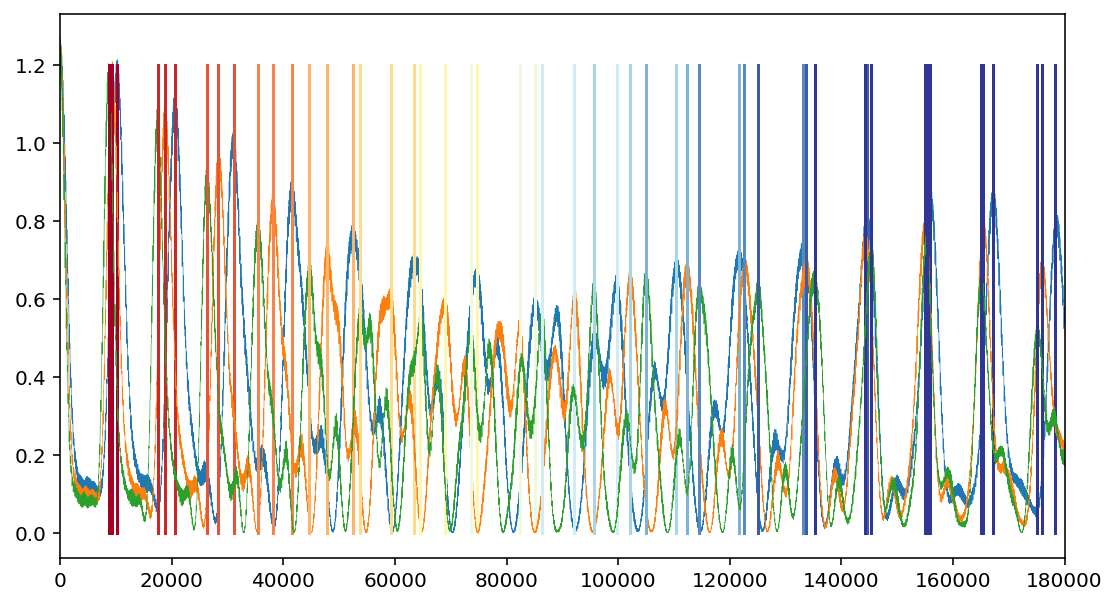

In [923]:
plt.xlim(0,180000)

plt.plot(τ *step*δt,E[1],lw=0.3,label="α=0.25")
for i in range(0,len(maxtime_E)):
    plt.plot(np.full(len(maxtime_E),maxtime_E[i]),np.linspace(0,1.2,len(maxtime_E)),color=plt.cm.RdYlBu(i*20))

plt.plot(τ *step*δt,E2[1],lw=0.3,label="α=0.30")
for i in range(0,len(maxtime_E2)):
    plt.plot(np.full(len(maxtime_E2),maxtime_E2[i]),np.linspace(0,1.2,len(maxtime_E2)),color=plt.cm.RdYlBu(i*20))
    
plt.plot(τ *step*δt,E3[1],lw=0.3,label="α=0.35")
for i in range(0,len(maxtime_E3)):
    plt.plot(np.full(len(maxtime_E3),maxtime_E3[i]),np.linspace(0,1.2,len(maxtime_E3)),color=plt.cm.RdYlBu(i*20))

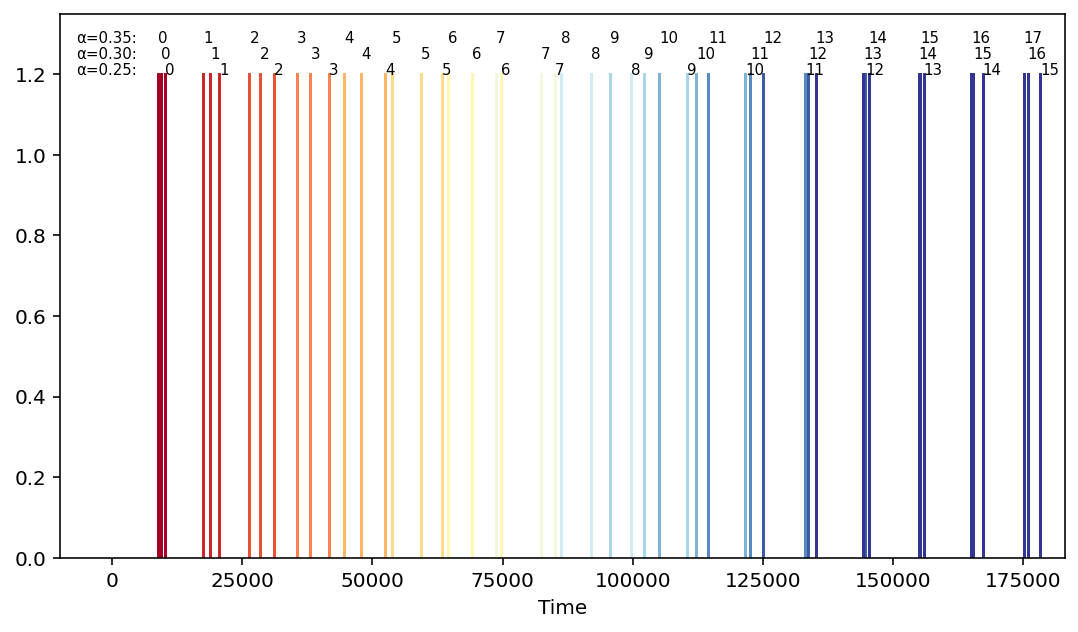

In [924]:
plt.text(-7000,1.2,"α=0.25:",fontsize=7.5)
plt.text(-7000,1.24,"α=0.30:",fontsize=7.5)
plt.text(-7000,1.28,"α=0.35:",fontsize=7.5)

for i in range(0,len(maxtime_E)):
    plt.plot(np.full(len(maxtime_E),maxtime_E[i]),np.linspace(0,1.2,len(maxtime_E)),color=plt.cm.RdYlBu(i*20))
    plt.text(maxtime_E[i],1.2,f"{i}",fontsize=7.5)
    
for i in range(0,len(maxtime_E2)):
    plt.plot(np.full(len(maxtime_E2),maxtime_E2[i]),np.linspace(0,1.2,len(maxtime_E2)),color=plt.cm.RdYlBu(i*20))
    plt.text(maxtime_E2[i],1.24,f"{i}",fontsize=7.5)
    
for i in range(0,len(maxtime_E3)):
    plt.plot(np.full(len(maxtime_E3),maxtime_E3[i]),np.linspace(0,1.2,len(maxtime_E3)),color=plt.cm.RdYlBu(i*20))
    plt.text(maxtime_E3[i],1.28,f"{i}",fontsize=7.5)

plt.xlim(-10000,183000)
plt.ylim(0,1.35)
plt.xlabel("Time")
plt.ticklabel_format(style='plain') # to prevent scientific notation.

We can see that the maximum values in the energy between each mode start at very similar times, and then interact with each other and create an odd behavior. We can see that around $t\approx 155000$ we return to somewhat of our initial condition, but the first modal energies of the system with a higher quadratic term reach it slower than the others.

So if we have a system with an $\alpha$ of $0.25$ reach a maximum at $t\approx 155000$ in 13 periods, we should see a system with $\alpha$ of $0.40$ reach this value in 16 periods if it follows the same trend as above:

In [925]:
P4,T4,X4,p4,E4,τ4 = create_fput(N,l,tmax,δt,F_quad,nlt=0.40,step=step)

In [926]:
maxtime_E4 = np.empty(20)
maxEnergy_E4 = np.empty(20)
for i in range(6000,180000,9000):
    maxEnergy_E4[int((i-6000)/9000)], maxtime_E4[int((i-6000)/9000)] = findMax(E4,1,i,i+9000)
maxtime_E4 = np.delete(maxtime_E4,-1)
maxEnergy_E4 = np.delete(maxEnergy_E4,-1)

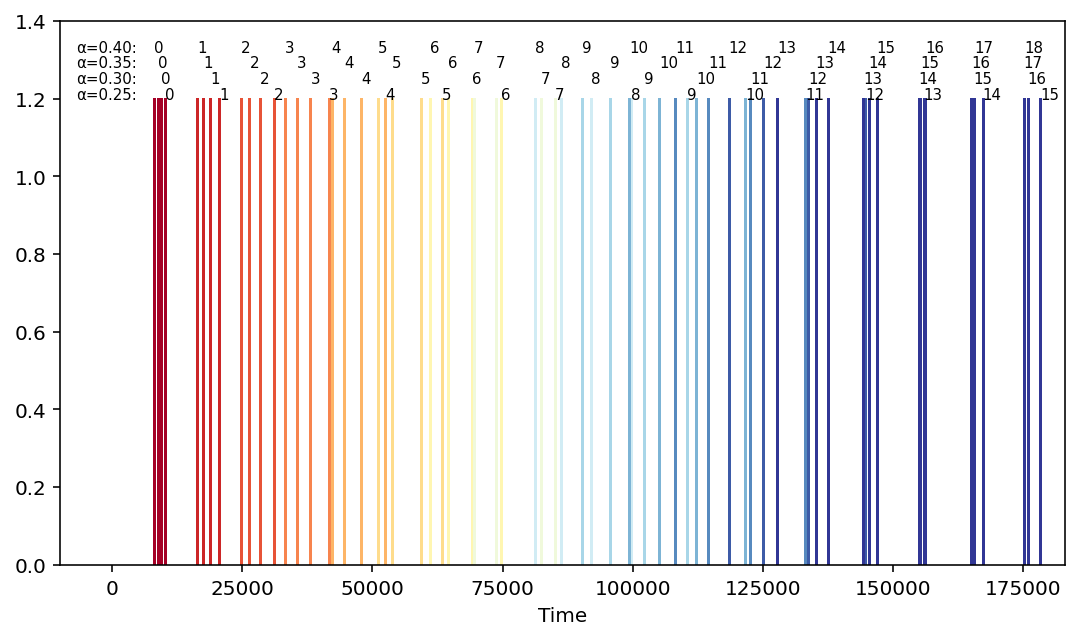

In [927]:
plt.text(-7000,1.2,"α=0.25:",fontsize=7.5)
plt.text(-7000,1.24,"α=0.30:",fontsize=7.5)
plt.text(-7000,1.28,"α=0.35:",fontsize=7.5)
plt.text(-7000,1.32,"α=0.40:",fontsize=7.5)

for i in range(0,len(maxtime_E)):
    plt.plot(np.full(len(maxtime_E),maxtime_E[i]),np.linspace(0,1.2,len(maxtime_E)),color=plt.cm.RdYlBu(i*20))
    plt.text(maxtime_E[i],1.2,f"{i}",fontsize=7.5)
    
for i in range(0,len(maxtime_E2)):
    plt.plot(np.full(len(maxtime_E2),maxtime_E2[i]),np.linspace(0,1.2,len(maxtime_E2)),color=plt.cm.RdYlBu(i*20))
    plt.text(maxtime_E2[i],1.24,f"{i}",fontsize=7.5)
    
for i in range(0,len(maxtime_E3)):
    plt.plot(np.full(len(maxtime_E3),maxtime_E3[i]),np.linspace(0,1.2,len(maxtime_E3)),color=plt.cm.RdYlBu(i*20))
    plt.text(maxtime_E3[i],1.28,f"{i}",fontsize=7.5)
    
for i in range(0,len(maxtime_E4)):
    plt.plot(np.full(len(maxtime_E4),maxtime_E4[i]),np.linspace(0,1.2,len(maxtime_E4)),color=plt.cm.RdYlBu(i*20))
    plt.text(maxtime_E4[i],1.32,f"{i}",fontsize=7.5)

plt.xlim(-10000,183000)
plt.ylim(0,1.40)
plt.xlabel("Time")
plt.ticklabel_format(style='plain') # to prevent scientific notation.

We can see that the prediction was true! It appears the number of periods a half-sine wave will take for its modal energies to return to their initial configurations (not to be confused with the system's initial configurations - this is referring to when we have the modal energies maxima equally spread out, like at $t=0$ and $t\approx 155000$) can be modelled.

We know that with $\alpha = 0.25$, we have a number of maximums (let's call this $N_{max}$) of 13. Every time we increase $\alpha$ by $0.05$, this value increases by $1$.

We can define our relation as:

$$
N_{max} \equiv 13 + \frac{\alpha - 0.25}{0.05} = 20\alpha + 8
$$

It is important to stress that this is only for the half-sine wave set-up. We found earlier that the initial configuration on the string has a complex effect on the behavior of the system.

Now, what about the cubic term?

In [928]:
%%time

step=200
tmax=350000

P0,T0,X0,p0,E0,τ0 = create_fput(N,l,tmax,δt,F_cubic,nlt=3.00,step=step)
P1,T1,X1,p1,E1,τ1 = create_fput(N,l,tmax,δt,F_cubic,nlt=3.50,step=step)
P2,T2,X2,p2,E2,τ2 = create_fput(N,l,tmax,δt,F_cubic,nlt=4.00,step=step)

CPU times: total: 3min 32s
Wall time: 3min 35s


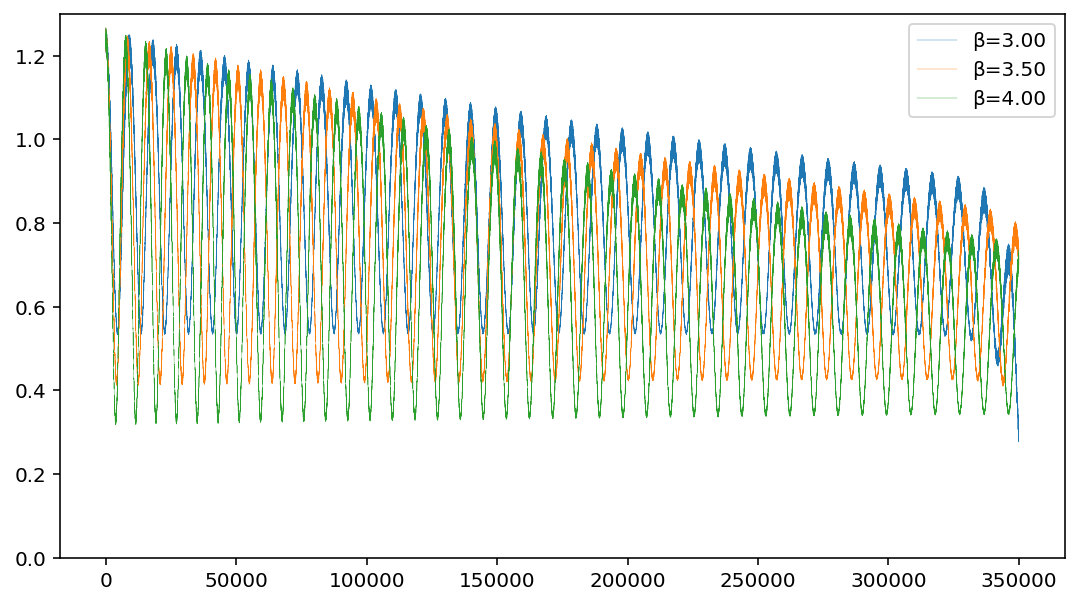

In [929]:
#plt.xlim(300000,400000)
plt.ylim(0,1.3)

plt.plot(τ0*step*δt,E0[1],lw=0.2,label="β=3.00")
plt.plot(τ1*step*δt,E1[1],lw=0.2,label="β=3.50")    
plt.plot(τ2*step*δt,E2[1],lw=0.2,label="β=4.00")

plt.legend()

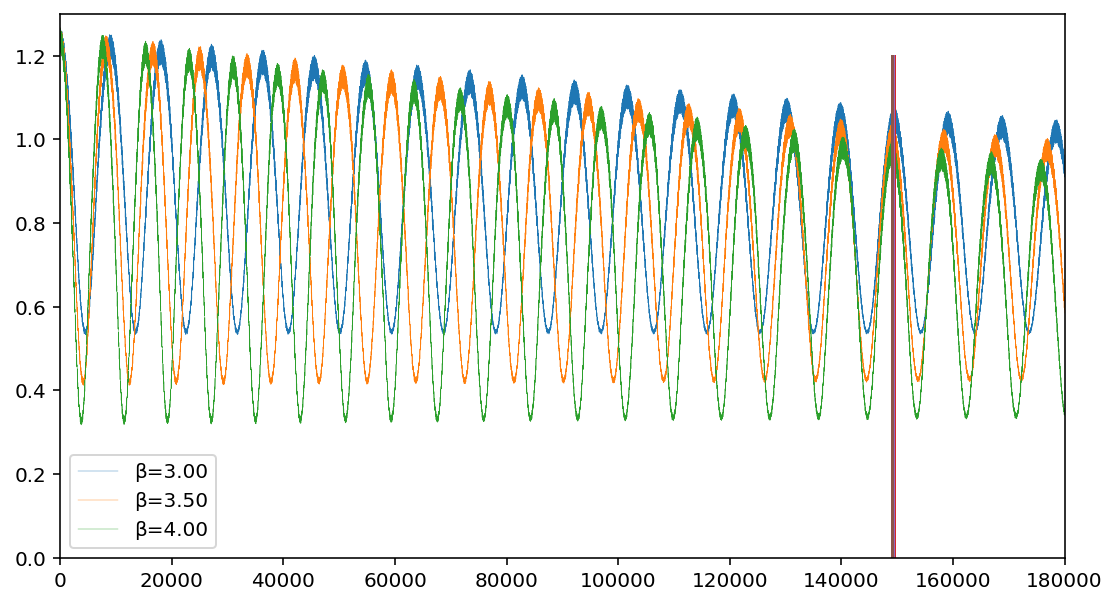

In [930]:
plt.xlim(0,180000)
plt.ylim(0,1.3)

plt.plot(τ0*step*δt,E0[1],lw=0.2,label="β=3.00")
plt.plot(τ1*step*δt,E1[1],lw=0.2,label="β=3.50")    
plt.plot(τ2*step*δt,E2[1],lw=0.2,label="β=4.00")

tmp = np.linspace(0,1.2,10)
e00,e01 = findMax(E0,1,146000,158000,200)
e10,e11 = findMax(E1,1,146000,158000,200)
e20,e21 = findMax(E2,1,146000,158000,200)

plt.plot(np.full(10,e01),tmp)
plt.plot(np.full(10,e11),tmp)
plt.plot(np.full(10,e21),tmp)

plt.legend()

If you count the periods of each wave, we can see that something very similar occurs! It also happens at $t\approx 155000$!

Let's find the relation for the cubic term:

We know that with $\beta = 3.00$, we have a number of maximums (let's call this $M_{max}$) of 15. Every time we increase $\beta$ by $0.50$, this value increases by $1$.

We can define our relation as:

$$
M_{max} \equiv 15 + \frac{\alpha - 3.00}{0.50} = 2\beta + 9
$$

Let's try this on $\beta = 4.50$, we should get 18 periods:

In [931]:
P3,T3,X3,p3,E3,τ3 = create_fput(N,l,tmax,δt,F_cubic,nlt=4.50,step=step)

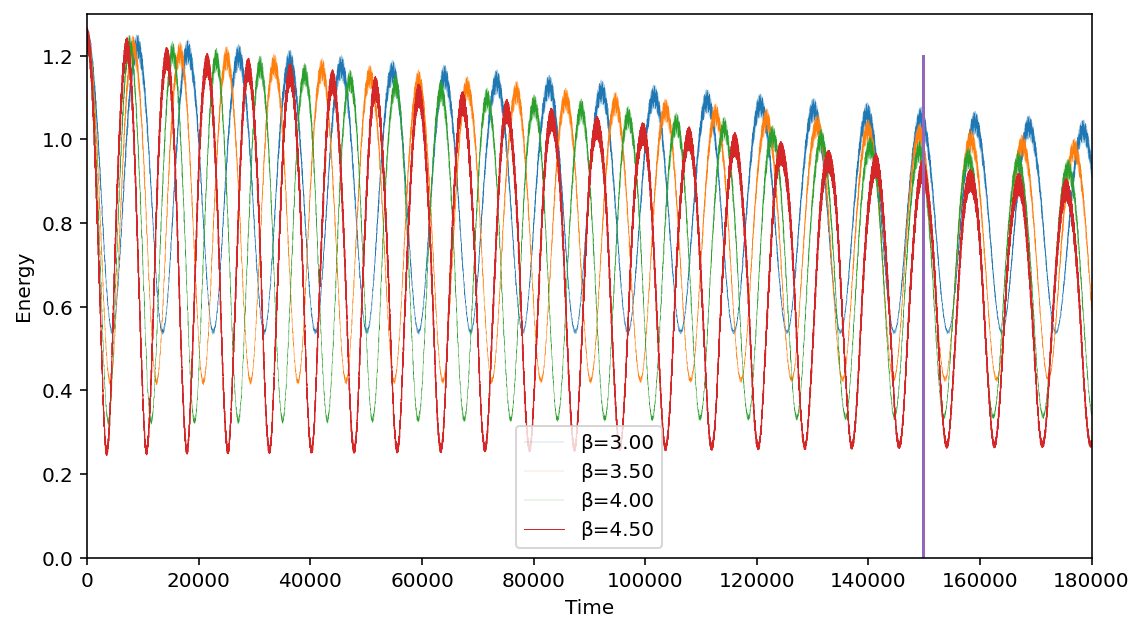

In [932]:
plt.xlim(0,180000)
plt.ylim(0,1.3)
plt.xlabel("Time")
plt.ylabel("Energy")
   
plt.plot(τ0*step*δt,E0[1],lw=0.1,label="β=3.00")
plt.plot(τ1*step*δt,E1[1],lw=0.1,label="β=3.50")    
plt.plot(τ2*step*δt,E2[1],lw=0.1,label="β=4.00")
plt.plot(τ3*step*δt,E3[1],lw=0.5,label="β=4.50")

e30,e31 = findMax(E3,1,145000,158000,200)

plt.plot(np.full(10,e31),tmp)

plt.legend()

Which again, happens here. We have 18 periods occur before this critical value

### Frequency at Small Periods

The idea here is to try to predict how quickly the first maximum will occur in the first modal energy (besides $t=0$).

The half-sine wave configuration will be examined. Recall the model for this:

$$
x_i = \sin(\frac{i\pi}{N+1})
$$

We can notice that the first maximum occurs quicker if our $\alpha$ term is larger. We will exploit this, and find a trend to predict this:

In [950]:
P1,T1,X1,p1,E1,τ1 = create_fput(32,124,30000,δt,force=F_quad,nlt=0.25,init=hsw,step=5)
P2,T2,X2,p2,E2,τ2 = create_fput(32,124,30000,δt,force=F_quad,nlt=0.75,init=hsw,step=5)

max for α=0.25 at: 9900.0
max for α=0.75 at: 5000.0


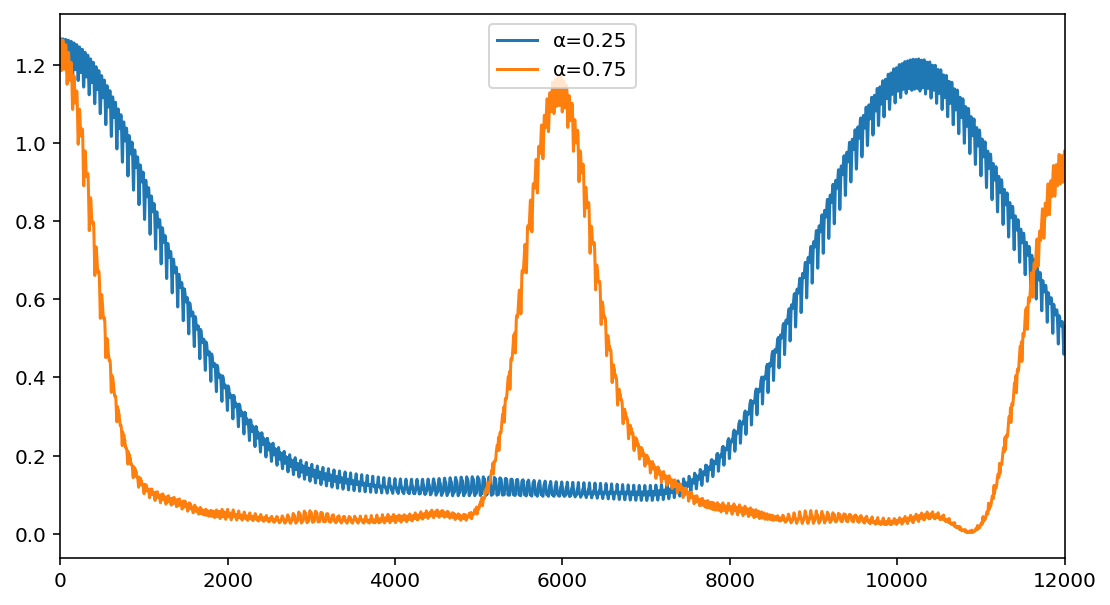

In [951]:
plt.xlim(0,12000)
plt.plot(τ1*5*δt,E1[1],label='α=0.25')
plt.plot(τ2*5*δt,E2[1],label='α=0.75')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.legend()
print(f"max for α=0.25 at: {findMax(E1,1,9000,12000)[1]}")
print(f"max for α=0.75 at: {findMax(E2,1,5000,7000)[1]}")

Now, we can grab the times at which the first maximum occurs in systems with different quadratic terms:

In [963]:
%%time

# hardcoded function used for finding maximums of each wave
def tmpf(x):
    return 2500/(x+0.1)

α_set  = np.empty(15,dtype=float)
tm_set = np.empty(15,dtype=float)

for it in range(1,16):
    α=it/10.0
    P,T,X,p,E,τ = create_fput(32,124,30000,δt,force=F_quad,nlt=α,init=hsw,step=5)
    α_set[it-1] = α
    tm_set[it-1] = findMax(E,1,tmpf(α),tmpf(α)+6000,5)[1]

CPU times: total: 6min 2s
Wall time: 6min 5s


Text(0, 0.5, 'First maximum')

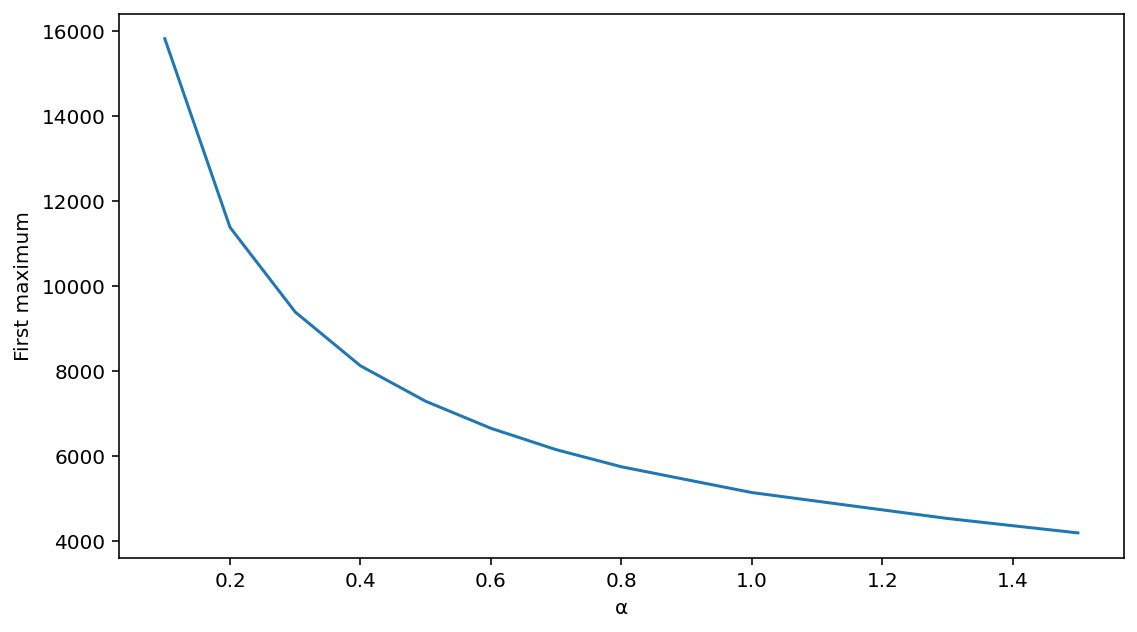

In [964]:
plt.plot(α_set,tm_set)
plt.xlabel('α')
plt.ylabel('First maximum')

To find a model that fits this curve, we can use `np.polyfit` and exploit logarithmic laws to find the coefficients that would satisfy the equation $E_{max} = A\alpha^B$, where $E_{max}$ is the maxima of the first modal energy and $\alpha$ is our quadratic term.

$$
E_{max} = A\alpha^B
$$

$$
\ln(E_{max}) = \ln(A\alpha^B) = \ln(A)+B\ln(\alpha)
$$

Since $\ln(1) = 0$, we can determine $A$ by using the point at $\alpha=1$:

In [965]:
print(f"α = {α_set[9]}")
print(f"E = {tm_set[9]}")

α = 1.0
E = 5142.0


$$
ln(5142) = ln(A)
$$

$$
A = 5142
$$

Now using this we can solve for $B$ using a point picked at $\alpha = 0.1$:

In [966]:
print(f"α = {α_set[0]}")
print(f"E = {tm_set[0]}")

α = 0.1
E = 15827.5


$$
\ln(15827.5) = \ln(5142) + B\ln(0.1)
$$

$$
B = \frac{\ln(\frac{15827.5}{5142})}{\ln(0.1)}
$$

$$
B \approx -0.488
$$

Therefore, we can modal the first period vs. the quadratic term with:

$$
E_{max} \equiv 5142\alpha^{-0.488}
$$

In [967]:
def Emax(α):
    return 5142*α**-0.488

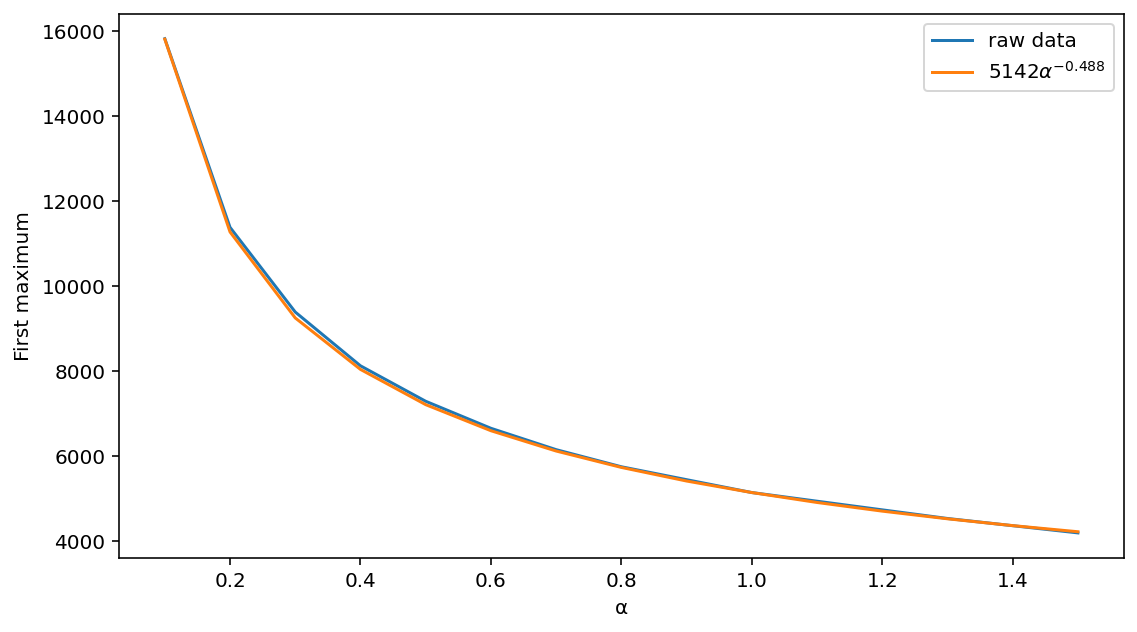

In [968]:
x = np.linspace(α_set[0],α_set[-1],len(α_set))
y = Emax(x)

plt.plot(α_set,tm_set,label='raw data')
plt.plot(x,y,label="5142$α^{-0.488}$")
plt.xlabel('α')
plt.ylabel('First maximum')

plt.legend()

Let's try this and see how it works on some other quadratic values

In [969]:
P1,T1,X1,p1,E1,τ1 = create_fput(32,124,30000,δt,force=F_quad,nlt=0.05,init=hsw,step=5)
P2,T2,X2,p2,E2,τ2 = create_fput(32,124,30000,δt,force=F_quad,nlt=1.43,init=hsw,step=5)
P3,T3,X3,p3,E3,τ3 = create_fput(32,124,30000,δt,force=F_quad,nlt=2.82,init=hsw,step=5)

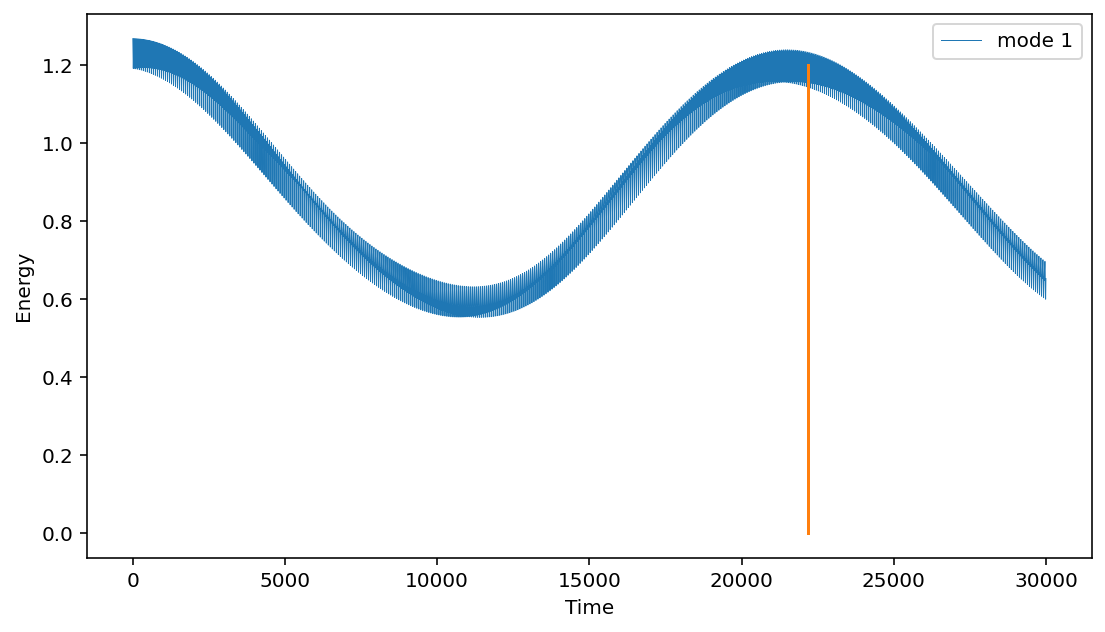

In [970]:
em1 = Emax(0.05)

#plt.xlim(0,em1*2)
plt.plot(τ1*5*δt,E1[1],lw=0.5,label="mode "+str(1))
plt.plot(np.full(50,em1),np.linspace(0,1.2,50))
plt.xlabel("Time")
plt.ylabel("Energy")
plt.legend()

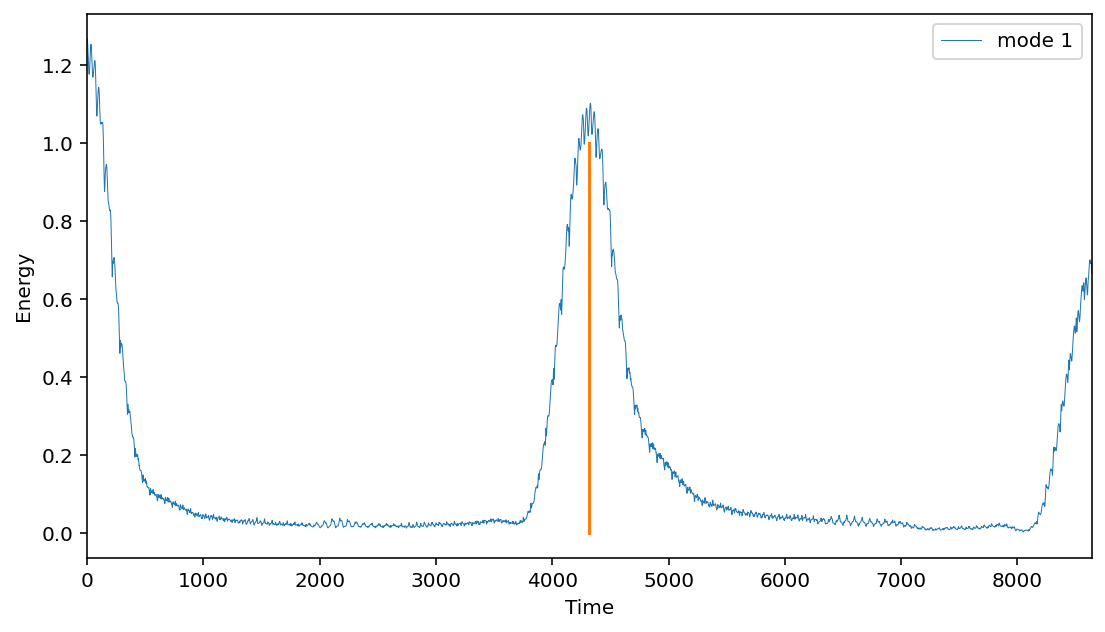

In [971]:
em2 = Emax(1.43)

plt.xlim(0,em2*2)
plt.plot(τ2*5*δt,E2[1],lw=0.5,label="mode "+str(1))
plt.plot(np.full(50,em2),np.linspace(0,1.0,50))
plt.xlabel("Time")
plt.ylabel("Energy")
plt.legend()

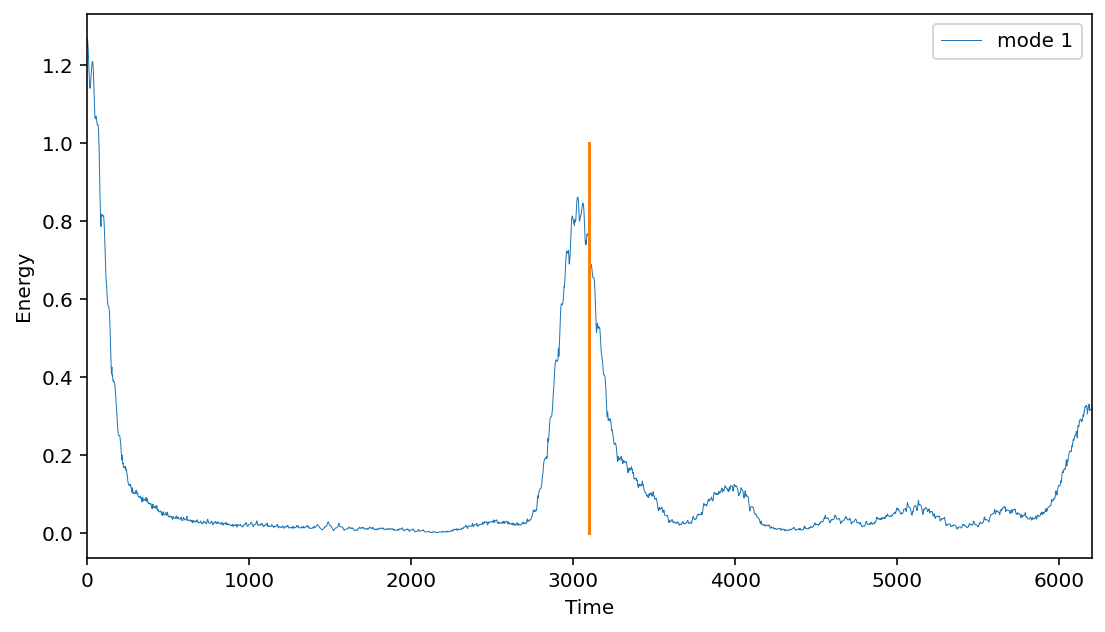

In [972]:
em3 = Emax(2.82)

plt.xlim(0,em3*2)
plt.plot(τ3*5*δt,E3[1],lw=0.5,label="mode "+str(1))
plt.plot(np.full(50,em3),np.linspace(0,1.0,50))
plt.xlabel("Time")
plt.ylabel("Energy")
plt.legend()

We can see that our results still produce accurate results, but as the quadratic term reaches values about greater than $2.50$, some of the accuracy starts to diminish.

### Note:

The highest time we chose to run the simulation over was $t=350000$. This was because of the instability that comes right after this point, especially with the cubic term, as shown below. The time step chosen was good enough to produce our desired results and keep the system stable.

Text(0, 0.5, 'Energy')

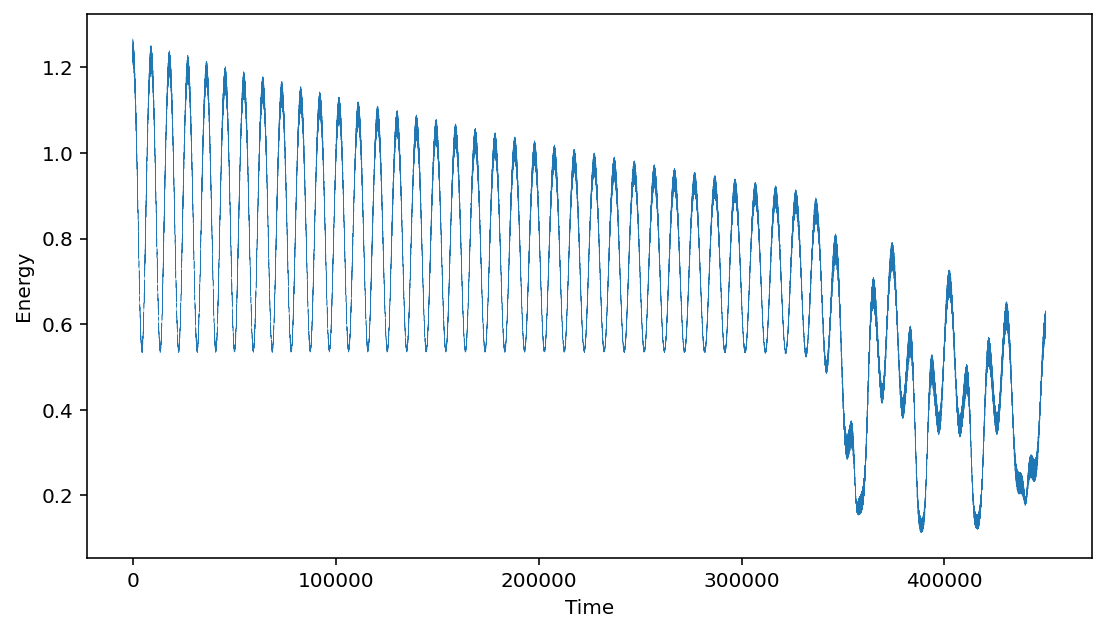

In [973]:
P0,T0,X0,p0,E0,τ0 = create_fput(N,l,450000,δt,F_cubic,nlt=3.00,step=200)
plt.plot(τ0*200*δt,E0[1],lw=0.2)
plt.xlabel('Time')
plt.ylabel('Energy')